In [121]:
import random
import numpy as np
import math
import scipy.special
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table

In [122]:
domains = {
    'x1': [i for i in range(0,16)],
    'x2': [i for i in range(0,11)],
    'x3': [i for i in range(0,26)],
    'x4': [i for i in range(0,5)],
    'x5': [i for i in range(0,31)],
}

In [123]:
costos=[164,310,46,111,12]

In [124]:
constraints = {
    ('x1', 'x2'): lambda x1, x2:  costos[0]*x1 <= 3800-costos[1]*x2,
    ('x2', 'x1'): lambda x2, x1:  3800-costos[1]*x2 >= costos[0]*x1,
    ('x3', 'x4'): lambda x3, x4:  costos[2]*x3 <= 2800-costos[3]*x4,
    ('x4', 'x3'): lambda x4, x3:  2800-costos[3]*x4 >= costos[2]*x3,
    ('x3', 'x5'): lambda x3, x5:  costos[2]*x3 <= 3500-costos[4]*x5,
    ('x5', 'x3'): lambda x5, x3:  3500-costos[4]*x5 >= costos[2]*x3,
}

In [125]:
def revise(x, y):
    revised = False
    x_domain = domains[x]
    y_domain = domains[y]
    all_constraints = [
        constraint for constraint in constraints if constraint[0] == x and constraint[1] == y]
    for x_value in x_domain:
        satisfies = False
        for y_value in y_domain:
            for constraint in all_constraints:
                constraint_func = constraints[constraint]
                if constraint_func(x_value, y_value):
                    satisfies = True
        if not satisfies:
            x_domain.remove(x_value)
            revised = True
    return revised

def ac3(arcs):
    queue = arcs[:]
    while queue:
        (x, y) = queue.pop(0)
        revised = revise(x, y)
        if revised:
            neighbors = [neighbor for neighbor in arcs if neighbor[1] == x]
            queue = queue + neighbors

In [126]:
arcs = [
    ('x1', 'x2'), ('x2', 'x1'),
    ('x3', 'x4'), ('x4', 'x3'),
    ('x3', 'x5') ,('x5', 'x3'),
]

In [127]:
ac3(arcs)

In [128]:
def sigmoide(x, alpha, x0):
    return 1/(1+np.exp(-alpha*(x-x0)))

In [129]:
def find_y_interval(y, intervals):
    interval_width = 1 / intervals
    for i in range(intervals):
        if i * interval_width <= y < (i + 1) * interval_width:
            return i
    return intervals - 1 if y == 1 else None

In [130]:
def master_sigmoide(arreglo):
    parameters = [
        (0.6, 7.5, 16),    
        (1, 5, 11),        
        (0.35, 12.5, 26),  
        (2.5, 2, 5),       
        (0.3, 15, 31)      
    ]
    
    results = []
    for x, (alpha, x0, intervals) in zip(arreglo, parameters):
        y = sigmoide(x, alpha, x0)
        if intervals == 5: 
            if 0 <= y < 0.2:
                results.append(0)
            elif 0.2 <= y < 0.4:
                results.append(1)
            elif 0.4 <= y < 0.6:
                results.append(2)
            elif 0.6 <= y < 0.8:
                results.append(3)
            elif 0.8 <= y <= 1:
                results.append(4)
            else:
                results.append(None)
        else:
            results.append(find_y_interval(y, intervals))
    
    return results

In [131]:
def maximizar(x):
    x1,x2,x3,x4,x5=x
    return 67*x1+91*x2+43*x3+71*x4+23*x5

In [132]:
def minimizar(x):
    x1,x2,x3,x4,x5=x
    return 164*x1+310*x2+46*x3+111*x4+12*x5

In [133]:
def restricciones(x):
    x1,x2,x3,x4,x5=x
    return (0<= x1 and x1<=15 and 0<=x2 and x2<=10 and 0<=x3 and x3<=25 and 0<=x4 and x4<=4 and 0<=x5 and x5<=30 \
            and 164*x1+310*x2<=3800 and 46*x3+111*x4<= 2800 and 46*x3+13*x5<= 3500)

In [134]:
def scalarizing(x, wmax, wmin):
    cap=4000
    fracmax=(maximizar(x))/3418
    fracmin=(cap-(minimizar(x))) / (cap-0)
    return wmax*fracmax + wmin*fracmin

In [135]:
def Cl() -> float:
    return random.uniform(0.674,1.5)

In [136]:
def gliding():
    ro = 1.204#𝜌
    hg = 8
    V = 5.25
    S = 154
    Gc = 1.9
    Cd = 0.60
    L = 1 / 2 * (ro * (Cl()) * (V**2) * S)
    D = 1 / 2 * (ro * (V**2) * S * Cd)
    artc = np.arctan(D / L)
    dg = hg / np.tan(artc)
    sf = 18
    return dg / sf


In [137]:
def rho():
    beta=1.5
    return ((scipy.special.gamma(beta+1)*np.sin((math.pi*beta)/2))/ \
     (scipy.special.gamma((1+beta)/2)*beta*(2)**((beta-1)/2)))**(1/beta)

In [138]:
lower_band=[domains[f"x{i+1}"][0] for i in range(len(domains.keys()))]
upper_band=[domains[f"x{i+1}"][-1] for i in range(len(domains.keys()))]

In [139]:
def levy():
    beta = 1.5
    sigma = (scipy.special.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
             (scipy.special.gamma((1 + beta) / 2) * beta * 2**((beta - 1) / 2)))**(1 / beta)
    u = np.random.normal(0, sigma, size=len(lower_band)) 
    v = np.random.normal(0, 1, size=len(lower_band)) 
    step = u / np.abs(v)**(1 / beta)
    return 0.01 * step

In [140]:
def randomloc(index):
    return lower_band[index] + levy()[index] * (upper_band[index] - lower_band[index]) 

In [141]:
def actualizar_valores(i, ref_vector, Pdp):
    for u, v in enumerate(i):
        if random.uniform(0, 1) >= Pdp:
            new_value = v + gliding() * 1.9 * (ref_vector[u] - v)
        else:
            new_value = randomloc(u)
        i[u] = new_value
    return master_sigmoide(np.clip(i, lower_band, upper_band))

In [142]:
def Smin(t,maxiter):
    return (10 * 10**-6)/(365**(t/(maxiter/2.5)))

In [143]:
def main(maxiter,popsize,wmax,wmin):
    FS=[]
    for i in range(popsize):
        while True
            aux=master_sigmoide([random.uniform(lower_band[j], upper_band[j]) for j in range(len(lower_band))])
            if restricciones(aux):
                break
        FS.append(aux)

    fitness_values = [scalarizing(ind,wmax,wmin) for ind in FS]

    FS = [x for _, x in sorted(zip(fitness_values, FS), key=lambda pair: pair[0])]

    trees = [1]
    if popsize > 1:
        trees.extend([2] * min(popsize - 1, 3))
    if popsize > 4:
        trees.extend(random.randint(3, 4) for _ in range(popsize - 4))
    Pdp=0.01

    for iterable in range(maxiter):
        Sc = []
        for j, i in enumerate(FS[1:4]):
            resta = 0
            while True:
                FS[j + 1] = actualizar_valores(i, FS[0], Pdp)
                if restricciones(FS[j + 1]):
                    break
            resta = np.array(i) - np.array(FS[0])
            resta = np.sqrt(np.sum(resta**2))
            Sc.append(resta)

        for idx, j in enumerate(FS[4:]):
            if trees[idx + 4] == 3:
                ref_vector = random.choice(FS[1:4])
            else:
                ref_vector = FS[0]
            
            FS[idx + 4] = actualizar_valores(j, ref_vector, Pdp)

            
        for idx, value in enumerate(Sc):
            if value < Smin(iterable, maxiter):

                for i in range(len(FS[idx + 1])):
                    FS[idx + 1][i] = randomloc(i)

                FS[idx + 1] = master_sigmoide(np.clip(FS[idx + 1], lower_band, upper_band))

        fitness_values = [scalarizing(ind,wmax,wmin) for ind in FS]

        FS = [x for _, x in sorted(zip(fitness_values, FS), key=lambda pair: pair[0])]

        trees = [1]
        if popsize > 1:
            trees.extend([2] * min(popsize - 1, 3))
        if popsize > 4:
            trees.extend(random.randint(3, 4) for _ in range(popsize - 4))
            
    return FS

In [147]:
repeticiones=10
resultados={}
for i in np.arange(0.0, 1.1, 0.20):
    # print(f"{i}-{1-i}")
    resultados[f"{i}-{1-i}"]=[]
    cons=Console()
    tabla=Table(title=f"SSA FS resultantes con factores {i} y {1-i}",show_header=True,header_style="bold magenta")
    tabla.add_column("FS",justify="full",no_wrap=True)
    tabla.add_column("Maximizacion",style="dim",justify="full",no_wrap=True)
    tabla.add_column("Minimizacion",style="dim",justify="full")
    tabla.add_column("Scalarizing",style="dim",justify="full")
    tabla.add_column("Restricciones",style="dim",justify="full")
    for j in range(repeticiones):
        FS=main(100,10,i,1-i)
        resultados[f"{i}-{1-i}"].append([maximizar(FS[0]),minimizar(FS[0])])
        for j in FS:
            tabla.add_row(str(j),str(maximizar(j)),str(minimizar(j)),str(scalarizing(j,i,1-i)),str(restricciones(j)))
    cons.print(tabla)

                     SSA FS resultantes con factores 0.0 y 1.0                     
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                  ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 10, 25, 4, 30] │ 3964         │ 7514         │ -0.8785     │ False         │
│ [15, 10, 25, 4, 30] │ 3964         │ 7514         │ -0.8785     │ False         │
│ [15, 10, 25, 4, 30] │ 3964         │ 7514         │ -0.8785     │ False         │
│ [15, 10, 25, 4, 30] │ 3964         │ 7514         │ -0.8785     │ False         │
│ [15, 10, 25, 4, 30] │ 3964         │ 7514         │ -0.8785     │ False         │
│ [15, 10, 25, 4, 30] │ 3964         │ 7514         │ -0.8785     │ False         │
│ [15, 10, 25, 4, 30] │ 3964         │ 7514         │ -0.8785     │ False         │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 1.0         │ True          │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 1.0         │ True          │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 1.0         │ True          │
│ [15, 10, 25, 4, 0]  │ 3274         │ 7154         │ -0.7885     │ False         │
│ [15, 10, 25, 4, 0]  │ 3274         │ 7154         │ -0.7885     │ False         │
│ [15, 10, 25, 4, 0]  │ 3274         │ 7154         │ -0.7885     │ False         │
│ [15, 10, 25, 4, 0]  │ 3274         │ 7154         │ -0.7885     │ False         │
│ [15, 10, 25, 4, 0]  │ 3274         │ 7154         │ -0.7885     │ False         │
│ [15, 10, 25, 4, 0]  │ 3274         │ 7154         │ -0.7885     │ False         │
│ [15, 10, 25, 4, 0]  │ 3274         │ 7154         │ -0.7885     │ False         │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 1.0         │ True          │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 1.0         │ True          │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 1.0         │ True          │
│ [15, 10, 25, 4, 0]  │ 3274         │ 7154         │ -0.7885     │ False         │
│ [15, 10, 25, 4, 0]  │ 3274         │ 7154         │ -0.7885     │ False         │
│ [15, 10, 25, 4, 0]  │ 3274         │ 7154         │ -0.7885     │ False         │
│ [15, 10, 25, 4, 0]  │ 3274         │ 7154         │ -0.7885     │ False         │
│ [0, 10, 25, 4, 0]   │ 2269         │ 4694         │ -0.1735     │ True          │
│ [0, 10, 25, 4, 0]   │ 2269         │ 4694         │ -0.1735     │ True          │
│ [0, 10, 25, 4, 0]   │ 2269         │ 4694         │ -0.1735     │ True          │
│ [0, 10, 25, 4, 0]   │ 2269         │ 4694         │ -0.1735     │ True          │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 1.0         │ True          │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 1.0         │ True          │
│ [15, 10, 25, 0, 30] │ 3680         │ 7070         │ -0.7675     │ False         │
│ [15, 10, 25, 0, 30] │ 3680         │ 7070         │ -0.7675     │ False         │
│ [15, 10, 25, 0, 30] │ 3680         │ 7070         │ -0.7675     │ False         │
│ [15, 10, 25, 0, 30] │ 3680         │ 7070         │ -0.7675     │ False         │
│ [15, 10, 25, 0, 30] │ 3680         │ 7070         │ -0.7675     │ False         │
│ [15, 10, 0, 0, 30]  │ 2605         │ 5920         │ -0.48       │ False         │
│ [0, 10, 25, 0, 30]  │ 2675         │ 4610         │ -0.1525     │ True          │
│ [0, 10, 25, 0, 30]  │ 2675         │ 4610         │ -0.1525     │ True          │
│ [0, 10, 25, 0, 30]  │ 2675         │ 4610         │ -0.1525     │ True          │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 1.0         │ True          │
│ [15, 10, 25, 4, 0]  │ 3274         │ 7154         │ -0.7885     │ False         │
│ [15, 10, 25, 4, 0]  │ 3274         │ 7154         │ -0.7885     │ False         │
│ [15, 10, 25, 4, 0]  │ 3274         │ 7154         │ -0.7885     │ False         │
│ [15, 10, 25, 4, 0]  │ 3274         │ 7154         

                         SSA FS resultantes con factores 0.2 y 0.8                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                  ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing          ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 10, 25, 4, 30] │ 3964         │ 7514         │ -0.4708514921006436  │ False         │
│ [15, 10, 25, 4, 30] │ 3964         │ 7514         │ -0.4708514921006436  │ False         │
│ [15, 10, 25, 4, 30] │ 3964         │ 7514         │ -0.4708514921006436  │ False         │
│ [15, 10, 25, 4, 30] │ 3964         │ 7514         │ -0.4708514921006436  │ False         │
│ [15, 10, 25, 4, 30] │ 3964         │ 7514         │ -0.4708514921006436  │ False         │
│ [15, 10, 25, 4, 30] │ 3964         │ 7514         │ -0.4708514921006436  │ False         │
│ [15, 10, 25, 4, 30] │ 3964         │ 7514         │ -0.4708514921006436  │ False         │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 0.8                  │ True          │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 0.8                  │ True          │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 0.8                  │ True          │
│ [15, 10, 0, 0, 30]  │ 2605         │ 5920         │ -0.23157167934464598 │ False         │
│ [15, 10, 0, 0, 30]  │ 2605         │ 5920         │ -0.23157167934464598 │ False         │
│ [15, 10, 0, 0, 30]  │ 2605         │ 5920         │ -0.23157167934464598 │ False         │
│ [15, 10, 0, 0, 30]  │ 2605         │ 5920         │ -0.23157167934464598 │ False         │
│ [15, 10, 0, 0, 30]  │ 2605         │ 5920         │ -0.23157167934464598 │ False         │
│ [15, 10, 0, 0, 30]  │ 2605         │ 5920         │ -0.23157167934464598 │ False         │
│ [15, 10, 0, 0, 30]  │ 2605         │ 5920         │ -0.23157167934464598 │ False         │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 0.8                  │ True          │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 0.8                  │ True          │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 0.8                  │ True          │
│ [15, 10, 25, 0, 30] │ 3680         │ 7070         │ -0.3986693973083675  │ False         │
│ [15, 10, 25, 0, 30] │ 3680         │ 7070         │ -0.3986693973083675  │ False         │
│ [15, 10, 25, 0, 30] │ 3680         │ 7070         │ -0.3986693973083675  │ False         │
│ [15, 10, 25, 0, 30] │ 3680         │ 7070         │ -0.3986693973083675  │ False         │
│ [15, 10, 25, 0, 30] │ 3680         │ 7070         │ -0.3986693973083675  │ False         │
│ [15, 10, 25, 0, 30] │ 3680         │ 7070         │ -0.3986693973083675  │ False         │
│ [15, 10, 25, 0, 30] │ 3680         │ 7070         │ -0.3986693973083675  │ False         │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 0.8                  │ True          │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 0.8                  │ True          │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 0.8                  │ True          │
│ [15, 10, 0, 0, 30]  │ 2605         │ 5920         │ -0.23157167934464598 │ False         │
│ [15, 10, 0, 0, 30]  │ 2605         │ 5920         │ -0.23157167934464598 │ False         │
│ [15, 10, 0, 0, 30]  │ 2605         │ 5920         │ -0.23157167934464598 │ False         │
│ [15, 10, 0, 0, 30]  │ 2605         │ 5920         │ -0.23157167934464598 │ False         │
│ [15, 10, 0, 0, 30]  │ 2605         │ 5920         │ -0.23157167934464598 │ False         │
│ [15, 10, 0, 0, 30]  │ 2605         │ 5920         │ -0.23157167934464598 │ False         │
│ [15, 10, 0, 0, 30]  │ 2605         │ 5920         │ -0.23157167934464598 │ False         │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 0.8                  │ True          │
│ [0, 0, 0, 0, 0]     │ 0            │ 0            │ 0.8                  │ True          │
│

                         SSA FS resultantes con factores 0.4 y 0.6                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing          ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6                  │ True          │
│ [15, 10, 0, 4, 0]  │ 2199         │ 6004         │ -0.04325652428320653 │ False         │
│ [15, 10, 0, 4, 0]  │ 2199         │ 6004         │ -0.04325652428320653 │ False         │
│ [15, 10, 0, 4, 0]  │ 2199         │ 6004         │ -0.04325652428320653 │ False         │
│ [15, 10, 0, 4, 0]  │ 2199         │ 6004         │ -0.04325652428320653 │ False         │
│ [15, 10, 0, 4, 0]  │ 2199         │ 6004         │ -0.04325652428320653 │ False         │
│ [15, 10, 0, 4, 0]  │ 2199         │ 6004         │ -0.04325652428320653 │ False         │
│ [15, 10, 0, 4, 0]  │ 2199         │ 6004         │ -0.04325652428320653 │ False         │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6                  │ True          │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.2685530134581627   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.2685530134581627   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.2685530134581627   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.2685530134581627   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6                  │ True          │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [15, 10, 25, 4, 0] │ 3274         │ 7154         │ -0.08995196021064944 │ False         │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0     

         SSA FS resultantes con factores 0.6000000000000001 y 0.3999999999999999         
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.3999999999999999  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.3999999999999999  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.3999999999999999  │ True          │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.3999999999999999  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.3999999999999999  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.3999999999999999  │ True          │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.3999999999999999  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.3999999999999999  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.3999999999999999  │ True          │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [15, 10, 0, 0, 0] │ 1915         │ 5560         │ 0.1801614979520188  │ False         │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.3999999999999999  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.3999999999999999  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.3999999999999999  │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 310

               SSA FS resultantes con factores 0.8 y 0.19999999999999996               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

                   SSA FS resultantes con factores 1.0 y 0.0                   
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │


In [145]:
resultados

{'0.0-1.0': [[3680, 7070],
  [3680, 7070],
  [3274, 7154],
  [3274, 7154],
  [2889, 6364],
  [3964, 7514],
  [3680, 7070],
  [3343, 7190],
  [3274, 7154],
  [3964, 7514]],
 '0.2-0.8': [[3018, 6502],
  [3964, 7514],
  [3274, 7154],
  [2932, 6410],
  [3274, 7154],
  [3964, 7514],
  [3964, 7514],
  [3274, 7154],
  [3274, 7154],
  [3274, 7154]],
 '0.4-0.6': [[2199, 6004],
  [2199, 6004],
  [2199, 6004],
  [3274, 7154],
  [2199, 6004],
  [2990, 6710],
  [3274, 7154],
  [2990, 6710],
  [2990, 6710],
  [2242, 6050]],
 '0.6000000000000001-0.3999999999999999': [[1000, 3276],
  [1915, 5560],
  [910, 3100],
  [1915, 5560],
  [1915, 5560],
  [1915, 5560],
  [1915, 5560],
  [1915, 5560],
  [1005, 2460],
  [1915, 5560]],
 '0.8-0.19999999999999996': [[0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0]],
 '1.0-0.0': [[0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0],
  [0, 0]]}

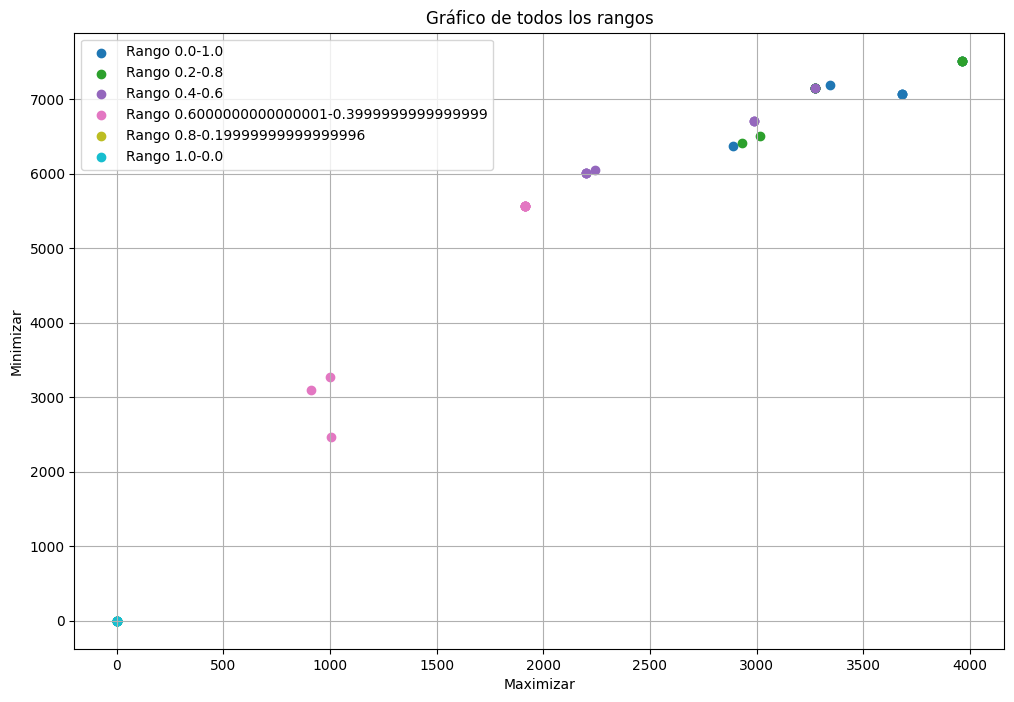

In [146]:
plt.figure(figsize=(12, 8))
plt.title('Gráfico de todos los rangos')
plt.xlabel('Maximizar')
plt.ylabel('Minimizar')

# Diferentes colores para cada rango
colors = plt.get_cmap('tab10', len(resultados))

# Iterar sobre cada conjunto de datos y agregar al gráfico
for idx, (key, values) in enumerate(resultados.items()):
    x_values = [v[0] for v in values]
    y_values = [v[1] for v in values]
    
    plt.scatter(x_values, y_values, label=f'Rango {key}', color=colors(idx))

# Mostrar leyenda y cuadrícula
plt.legend()
plt.grid(True)
plt.show()